<a href="https://colab.research.google.com/github/AlbertoPerezGant/Purchases-optimization-in-supply-chain-using-reinforcement-learning/blob/main/purchases_optimization_version_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction: Purchases optimization in inventory management.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In first place, libraries as gymnasium and stable_baseline3 are installed.


In [3]:
!pip install gymnasium==0.29.1
!pip install stable_baselines3==2.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manyl

# 2. Enviroment

**Definition** Lets generate a rangom distribution for a certain inventary

Source: https://kunalbharadkar.medium.com/reinforcement-learning-on-supply-chain-management-718be44ae8d2

Source2: https://towardsdatascience.com/a-reinforcement-learning-based-inventory-control-policy-for-retailers-ac35bc592278

(array([24., 94., 96., 34., 20., 26., 24., 30., 10.,  6.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

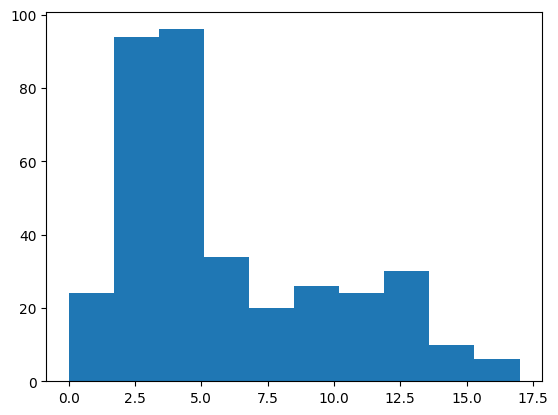

In [4]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(0)
demand_hist = []

# For a range of 52 weeks in a year
for i in range(52):

    for j in range(4):
        random_demand = np.random.normal(3, 1.5)

        if random_demand < 0:
            random_demand = 0

        random_demand = np.round(random_demand)
        demand_hist.append(random_demand)

    random_demand = np.random.normal(6, 1)

    if random_demand < 0:
        random_demand = 0

    random_demand = np.round(random_demand)
    demand_hist.append(random_demand)

    for j in range(2):
        random_demand = np.random.normal(12, 2)

        if random_demand < 0:
            random_demand = 0

        random_demand = np.round(random_demand)
        demand_hist.append(random_demand)

plt.hist(demand_hist)

## 2.1 Original Enviroment

We are going to initialize the original enviroment, so it will be compared with the random one for the same demand history.

In [5]:
class originalEnv():
    def __init__(self, demand_records):
        self.n_period = len(demand_records)
        self.current_period = 1
        self.day_of_week = 0
        self.inv_level = 25
        self.inv_pos = 25
        self.capacity = 50
        self.holding_cost = 3
        self.unit_price = 30
        self.fixed_order_cost = 50
        self.variable_order_cost = 10
        self.lead_time = 2
        self.order_arrival_list = []
        self.demand_list = demand_records
        self.state = np.array([self.inv_pos] + self.convert_day_of_week(self.day_of_week))
        self.state_list = []
        self.state_list.append(self.state)
        self.action_list = []
        self.reward_list = []

    def reset(self):
        self.state_list = []
        self.action_list = []
        self.reward_list = []
        self.inv_level = 25
        self.inv_pos = 25
        self.current_period = 1
        self.day_of_week = 0
        self.state = np.array([self.inv_pos] + self.convert_day_of_week(self.day_of_week))
        self.state_list.append(self.state)
        self.order_arrival_list = []
        return self.state

    def step(self, action):
        if action > 0:
            y = 1
            self.order_arrival_list.append([self.current_period+self.lead_time, action])
        else:
            y = 0
        if len(self.order_arrival_list) > 0:
            if self.current_period == self.order_arrival_list[0][0]:
                self.inv_level = min(self.capacity, self.inv_level + self.order_arrival_list[0][1])
                self.order_arrival_list.pop(0)
        demand = self.demand_list[self.current_period-1]
        units_sold = demand if demand <= self.inv_level else self.inv_level
        reward = units_sold*self.unit_price-self.holding_cost*self.inv_level - y*self.fixed_order_cost \
                 -action*self.variable_order_cost
        self.inv_level = max(0,self.inv_level-demand)
        self.inv_pos = self.inv_level
        if len(self.order_arrival_list) > 0:
            for i in range(len(self.order_arrival_list)):
                self.inv_pos += self.order_arrival_list[i][1]
        self.day_of_week = (self.day_of_week+1)%7
        self.state = np.array([self.inv_pos] +self.convert_day_of_week(self.day_of_week))
        self.current_period += 1
        self.state_list.append(self.state)
        self.action_list.append(action)
        self.reward_list.append(reward)
        if self.current_period > self.n_period:
            terminate = True
        else:
            terminate = False
        return self.state, reward, terminate

    def convert_day_of_week(self,d):
        if d == 0:
            return [0, 0, 0, 0, 0, 0]
        if d == 1:
            return [1, 0, 0, 0, 0, 0]
        if d == 2:
            return [0, 1, 0, 0, 0, 0]
        if d == 3:
            return [0, 0, 1, 0, 0, 0]
        if d == 4:
            return [0, 0, 0, 1, 0, 0]
        if d == 5:
            return [0, 0, 0, 0, 1, 0]
        if d == 6:
            return [0, 0, 0, 0, 0, 1]

In [6]:
env_original = originalEnv(demand_hist)
print("The capacity of test enviroment is: ", env_original.capacity)

The capacity of test enviroment is:  50


## 2.2 Random enviroment

In [53]:
import gymnasium as gym
import random


class InventoryEnvObservation(gym.Env):


  def __init__(self, demand_records, type='random'):
    """
    Init function for the inventory observation enviroment.
    """
    self.n_period = len(demand_records) # Record of demands
    self.demand_list = demand_records
    self.type = type

    self.reset()

  def reset_kpis_product(self):
    """
    Reset the product KPIs
    """
    self.day_of_week = np.random.randint(0,6) # Current day of the week
    self.holding_cost = random.randint(1, 10) # Cost of holding an item in the inventary
    self.unit_price = random.randint(10, 100) # Price of the product
    self.fixed_order_cost = random.randint(10, 200) # Fixed cost to attemp an order
    # Variable order cost always will be lower or equal than the sell price
    self.variable_order_cost = self.unit_price*(random.uniform(0.2, 1)) # Variable cost to attemp an order
    self.lead_time = random.randint(1, 10) # Lead time to attemp an order

  def reset_stock_variables(self):
    """
    Reset stock variables
    """
    self.capacity = random.randint(50, 200) # Total capacity of the inventary
    self.inv_level = random.randint(10, min(self.capacity,100)) # Level of the inventary
    self.inv_pos = self.inv_level # Position of the inventary
    self.order_arrival_list = [] # Variable that stores the orders list

  def reset(self):
    """
    Reset function for the enviroment.
    """
    self.current_period = 1
    self.reset_kpis_product()
    self.reset_stock_variables()

    # State: inv position and day of the week
    self.state = self.get_state()
    self.state_size = len(self.state)

    self.state_list = []
    self.state_list.append(self.state)
    self.action_list = []
    self.reward_list = []

    return self.state


  def get_state(self):
    """
    Return the state that contains position, capacity, day of week and costs
    """
    if self.type == 'random':
      return np.array([self.inv_level, self.inv_pos, self.capacity] +
                      self.convert_day_of_week(self.day_of_week)+
                      [self.holding_cost,
                      self.unit_price,
                      self.fixed_order_cost,
                      self.variable_order_cost,
                      self.lead_time])
    elif self.type == 'original':
      return np.array([self.inv_pos] +
                      self.convert_day_of_week(self.day_of_week))
    else:
      print('The type of initialization must be \'random\' or \'original\'')


  def step(self, action):
    """
    Given an action, step function for the enviroment.
    """
    if action > 0:
      y = 1
      # Adds the order to the order list
      self.order_arrival_list.append([self.current_period +
                                        self.lead_time, action])
    else:
        y = 0

    if len(self.order_arrival_list) > 0:
      # If there is an order in transit, updates te inventory level
      if self.current_period == self.order_arrival_list[0][0]:
        self.inv_level = min(self.capacity,
                            self.inv_level + self.order_arrival_list[0][1])
        self.order_arrival_list.pop(0)

    # Calculates demand and units sold
    demand = self.demand_list[self.current_period-1]
    units_sold = demand if demand <= self.inv_level else self.inv_level

    # Calculates reward from sells and costs
    reward = (units_sold*self.unit_price) - \
     (self.holding_cost*self.inv_level) - \
      (y*self.fixed_order_cost) - \
       (action*self.variable_order_cost)

    # Updates inventary level
    self.inv_level = max(0, self.inv_level-demand)
    self.inv_pos = self.inv_level

    # Updates inventary position counting transit orders
    if len(self.order_arrival_list) > 0:
      for i in range(len(self.order_arrival_list)):
        self.inv_pos += self.order_arrival_list[i][1]

    # Moves forward next day of weeb
    self.day_of_week = (self.day_of_week+1)%7

    # Updates env state
    self.state = self.get_state()

    # Moves forward next period
    self.current_period += 1

    # Log the state, action and reward
    self.state_list.append(self.state)
    self.action_list.append(action)
    self.reward_list.append(reward)

    # Checks if final time period is reached and terminates.
    if self.current_period > self.n_period:
        terminate = True
    else:
        terminate = False

    return self.state, reward, terminate


  def convert_day_of_week(self, d):
    """
    Day of the week conversor given a number as parameter
    """
    if d == 0:
        return [0, 0, 0, 0, 0, 0]
    if d == 1:
        return [1, 0, 0, 0, 0, 0]
    if d == 2:
        return [0, 1, 0, 0, 0, 0]
    if d == 3:
        return [0, 0, 1, 0, 0, 0]
    if d == 4:
        return [0, 0, 0, 1, 0, 0]
    if d == 5:
        return [0, 0, 0, 0, 1, 0]
    if d == 6:
        return [0, 0, 0, 0, 0, 1]

Lets get a test enviroment that will be used for future operations.

In [8]:
env = InventoryEnvObservation(demand_hist)
print("The size of test enviroment is: ", env.state_size)
print("The capacity of test enviroment is: ", env.capacity)

STATE_SIZE = env.state_size

The size of test enviroment is:  14
The capacity of test enviroment is:  124


Next, lets build the DQN.

Source: https://towardsdatascience.com/a-reinforcement-learning-based-inventory-control-policy-for-retailers-ac35bc592278

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """ Actor (Policy) Model."""
    def __init__(self, state_size, action_size, seed, fc1_unit=128,
                 fc2_unit = 128):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_unit (int): Number of nodes in first hidden layer
            fc2_unit (int): Number of nodes in second hidden layer
        """
        super(QNetwork,self).__init__() ## calls __init__ method of nn.Module class
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,fc1_unit)
        self.fc2 = nn.Linear(fc1_unit,fc2_unit)
        self.fc3 = nn.Linear(fc2_unit,action_size)

    def forward(self,x):
        # x = state
        """
        Build a network that maps state -> action values.
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## 2.3 DQN

Following the DQN building, there is the Agent definition.

In [10]:
from collections import namedtuple, deque

## Importing the model (function approximator for Q-table)
# from model import QNetwork

import torch.optim as optim
from torch.optim import lr_scheduler

BUFFER_SIZE = int(5*1e5)  #replay buffer size
BATCH_SIZE = 128 # minibatch size
GAMMA = 0.99 # discount factor
TAU = 1e-3 # for soft update of target parameters
LR = 1e-4 # learning rate
UPDATE_EVERY = 4 # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent(torch.nn.Module):
    """Interacts with and learns form environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        =======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """

        super().__init__()

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        #Q- Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0


    def step(self, state, action, reward, next_step, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_step, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step+1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get radom subset and learn

            if len(self.memory)>BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience, GAMMA)

    def act(self, state, eps = 0):
        """Returns action for given state as per current policy
        Params
        =======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()

        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        #Epsilon -greedy action selction
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        =======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        ## TODO: compute and minimize the loss
        criterion = torch.nn.MSELoss()
        # Local model is one which we need to train so it's in training mode
        self.qnetwork_local.train()
        # Target model is one with which we need to get our target so it's in evaluation mode
        # So that when we do a forward pass with target model it does not calculate gradient.
        # We will update target model weights with soft_update function
        self.qnetwork_target.eval()
        #shape of output from the model (batch_size,action_dim) = (64,4)

        predicted_targets = self.qnetwork_local(states).gather(1,actions)
        with torch.no_grad():
            labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        # .detach() ->  Returns a new Tensor, detached from the current graph.
        labels = rewards + (gamma* labels_next*(1-dones))
        loss = criterion(predicted_targets,labels).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        =======
            local model (PyTorch model): weights will be copied from
            target model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(),
                                           local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)

class ReplayBuffer:
    """Fixed -size buffe to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])
        self.seed = random.seed(seed)

    def add(self,state, action, reward, next_state,done):
        """Add a new experience to memory."""
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory"""

        experiences = random.sample(self.memory,k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states,actions,rewards,next_states,dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Finally, train the DQN model. Here the size of the action space is 21. From 0 to 20.

In [11]:
# Definition of an agent for the original product model
agent_original = Agent(state_size=7, action_size=21, seed=0)

# Definition of an agent for the random product model
agent = Agent(state_size=STATE_SIZE, action_size=21, seed=0)

def dqn(env, agent, n_episodes= 1000, max_t = 10000, eps_start=1.0, eps_end = 0.01,
       eps_decay=0.995):
    """
    Deep Q-Learning

    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): mutiplicative factor (per episode) for decreasing epsilon

    """
    scores = [] # list containing score from each episode
    eps = eps_start

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0

        for t in range(max_t):
            action = agent.act(state,eps)
            next_state, reward, done = env.step(action)
            agent.step(state, action, reward, next_state, done)
            ## above step decides whether we will train(learn) the network
            ## actor (local_qnetwork) or we will fill the replay buffer
            ## if len replay buffer is equal to the batch size then we will
            ## train the network or otherwise we will add experience tuple in our
            ## replay buffer.
            state = next_state
            score += reward

            if done:
              if i_episode % 100 == 0:
                # Print the score each 100 episodes
                print('episode' + str(i_episode) + ': ', score)

              scores.append(score)
              break

        eps = max(eps*eps_decay,eps_end)## decrease the epsilon

    return scores

## 2.4 Training

Train the DQN for the original product enviroment

episode100:  -4741.0
episode200:  8252.0
episode300:  14616.0
episode400:  19259.0
episode500:  19461.0
episode600:  19312.0
episode700:  19793.0


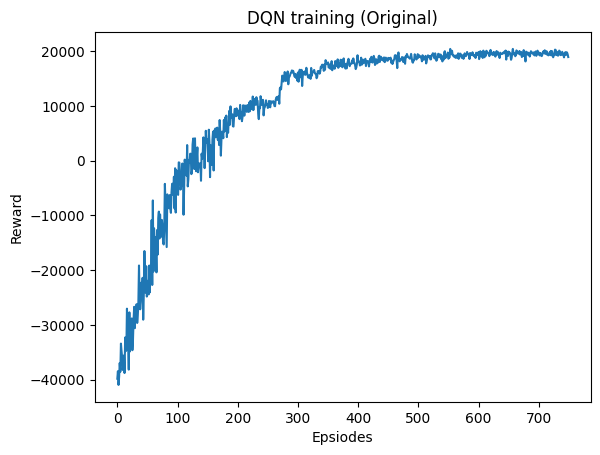

The model has been saved in: /content/drive/MyDrive/TFM Alberto Perez/Código/models/modelo_original.pt
CPU times: user 9min 44s, sys: 11.7 s, total: 9min 56s
Wall time: 10min 11s


In [12]:
%%time

desired_path_original = '/content/drive/MyDrive/TFM Alberto Perez/Código/models/modelo_original.pt'

env_original = originalEnv(demand_hist)
scores_original = dqn(env_original, agent_original, n_episodes=750)

plt.plot(np.arange(len(scores_original)), scores_original)
plt.ylabel('Reward')
plt.xlabel('Epsiodes')
plt.title('DQN training (Original)')
plt.show()

# Save the model in the defined path
if desired_path_original:
  try:
    torch.save(agent_original.qnetwork_local.state_dict(), desired_path_original)
    print('The model has been saved in: ' + desired_path_original)
  except:
    print("The given path is not available. Retrain and define a path for saving.")
else:
  print('The model has not been saved. Retrain and define a path for saving.')

Train the DQN for the random product enviroment

episode100:  -176864.5267687432
episode200:  -18367.03842741758
episode300:  -10085.362162855788
episode400:  47287.03370390427
episode500:  5216.973134927986
episode600:  -1081.4155799436746
episode700:  4009.383390016658


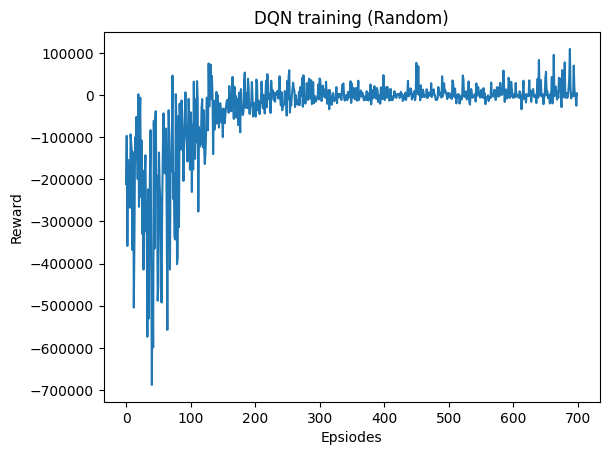

The model has been saved in: /content/drive/MyDrive/TFM Alberto Perez/Código/models/modelo_random.pt
CPU times: user 8min 40s, sys: 2.71 s, total: 8min 43s
Wall time: 8min 49s


In [13]:
%%time

desired_path_random = '/content/drive/MyDrive/TFM Alberto Perez/Código/models/modelo_random.pt'

env = InventoryEnvObservation(demand_hist)
scores = dqn(env, agent, n_episodes=700)

plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Reward')
plt.xlabel('Epsiodes')
plt.title('DQN training (Random)')
plt.show()

# Save the model in the defined path
if desired_path_random:
  try:
    torch.save(agent.qnetwork_local.state_dict(), desired_path_random)
    print('The model has been saved in: ' + desired_path_random)
  except:
    print("The given path is not available. Retrain and define a path for saving.")
else:
  print('The model has not been saved. Retrain and define a path for saving.')

The above plot represents the reward obtained form the model. It is seen that the reward improves until the number of episodes grows up.

# 3. Double DQN

Becaouse of the given result, it will be implemented a double DQN to improve its results. In the double DQN, the main network is the one choose the action with higher Q and the objective network the one that gives the objective value for Q and determines the final reward for the iteration.

The following code implements a double DQN agent.

Source: https://medium.com/@sainijagjit/understanding-dueling-dqn-a-deep-dive-into-reinforcement-learning-575f6fe4328c

In [14]:
class DoubleDQNAgent():
  """Interacts with and learns form environment."""

  def __init__(self, state_size, action_size, seed):
    """Initialize an Agent object.

    Params
    =======
        state_size (int): dimension of each state
        action_size (int): dimension of each action
        seed (int): random seed
    """

    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    #Q- Network
    self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
    self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)

    # Replay memory
    self.memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE,seed)
    # Initialize time step (for updating every UPDATE_EVERY steps)
    self.t_step = 0


  def step(self, state, action, reward, next_step, done):
    # Save experience in replay memory
    self.memory.add(state, action, reward, next_step, done)

    # Learn every UPDATE_EVERY time steps.
    self.t_step = (self.t_step + 1) % UPDATE_EVERY
    if self.t_step == 0:
      # If enough samples are available in memory, get radom subset and learn
      if len(self.memory) > BATCH_SIZE:
        experience = self.memory.sample()
        self.learn(experience, GAMMA)


  def act(self, state, eps = 0):
    """Returns action for given state as per current policy
    Params
    =======
        state (array_like): current state
        eps (float): epsilon, for epsilon-greedy action selection
    """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork_local.eval()

    with torch.no_grad():
        action_values = self.qnetwork_local(state)
    self.qnetwork_local.train()

    #Epsilon -greedy action selction
    if random.random() > eps:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self, experiences, gamma):
    """Update value parameters using given batch of experience tuples.
    Params
    =======
        experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
        gamma (float): discount factor
    """
    states, actions, rewards, next_states, dones = experiences

    # Get the expected Q values from local model
    predicted_targets = self.qnetwork_local(states).gather(1, actions)

    # Get the max predicted Q values from local model
    with torch.no_grad():
      labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

    # Compute Q targets for current states
    labels = rewards + (gamma * labels_next * (1 - dones))

    # Compute losss
    loss = F.mse_loss(predicted_targets, labels_next)
    # Minimize loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # ------------------- update target network ------------------- #
    self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)


  def soft_update(self, local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    =======
        local model (PyTorch model): weights will be copied from
        target model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter
    """
    for target_param, local_param in zip(target_model.parameters(),
                                         local_model.parameters()):
      target_param.data.copy_(tau*local_param.data + (1 - tau) * target_param.data)

In [15]:
# Definition of an agent for the double DQN model
agent_DDQN = DoubleDQNAgent(state_size=STATE_SIZE, action_size=21, seed=0)


def double_dqn(env, n_episodes= 1000, max_t = 10000, eps_start=1.0, eps_end = 0.01,
               eps_decay=0.995):
  """Deep Q-Learning

  Params
  ======
      n_episodes (int): maximum number of training epsiodes
      max_t (int): maximum number of timesteps per episode
      eps_start (float): starting value of epsilon, for epsilon-greedy action selection
      eps_end (float): minimum value of epsilon
      eps_decay (float): mutiplicative factor (per episode) for decreasing epsilon

  """
  scores = [] # list containing score from each episode
  eps = eps_start

  for i_episode in range(1, n_episodes + 1):
    state = env.reset()
    score = 0

    for t in range(max_t):
      action = agent_DDQN.act(state, eps)
      next_state, reward, done = env.step(action)
      agent_DDQN.memory.add(state, action, reward, next_state, done)

      state = next_state
      score += reward

      if len(agent_DDQN.memory) > BATCH_SIZE:
        experiences = agent_DDQN.memory.sample()
        agent_DDQN.learn(experiences, GAMMA)

      if done:
        if i_episode % 100 == 0:
          # Print the score each 100 episodes
          print('episode' + str(i_episode) + ': ', score)

        scores.append(score)
        break

    eps = max(eps * eps_decay, eps_end)## decrease the epsilon

  return scores

episode100:  -56003.01301093633
episode200:  -59128.137932731304
episode300:  -135893.18083481299
episode400:  -251118.5799168297
episode500:  -292010.11365542276
episode600:  -197663.26238729226
episode700:  -83655.71305691836


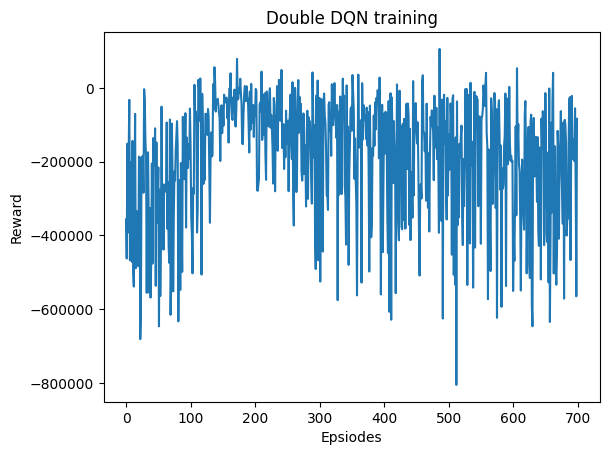

The model has been saved in: /content/drive/MyDrive/TFM Alberto Perez/Código/models/modelo_double.pt
CPU times: user 34min 18s, sys: 10.9 s, total: 34min 29s
Wall time: 34min 44s


In [16]:
%%time

desired_path_double = '/content/drive/MyDrive/TFM Alberto Perez/Código/models/modelo_double.pt'

env_double = InventoryEnvObservation(demand_hist)
scores_double = double_dqn(env_double, n_episodes=700)

plt.plot(np.arange(len(scores_double)),scores_double)
plt.ylabel('Reward')
plt.xlabel('Epsiodes')
plt.title('Double DQN training')
plt.show()

# TODO: Guardar el modelo en el fichero /models
# Save the model in the defined path
if desired_path_double:
  try:
    torch.save(agent.qnetwork_local.state_dict(), desired_path_double)
    print('The model has been saved in: ' + desired_path_double)
  except:
    print("The given path is not available. Retrain and define a path for saving.")
else:
  print('The model has not been saved. Retrain and define a path for saving.')

# 4. Optimizing the policy

Then, how the number of items (s) in the inventary get down of a limit, the order must be of a quantity of (S) units considering the delay time from the order and reposition.

For s, it can be never lower than 0, so it has no sense.

For S, it can be a little bit higher than capacity because the order do not have to arrive inmediately and there may be demand arrivals during the lead time.

Here S go from 1 to capacity + 10.

In [17]:
def profit_calculation_sS(s,
                          S,
                          demand_records,
                          total_profit=0,
                          inv_level=25,
                          lead_time=2,
                          capacity=50,
                          holding_cost=3,
                          fixed_order_cost=50,
                          unit_price=30,
                          variable_order_cost=None):

  if not variable_order_cost:
    variable_order_cost = fixed_order_cost * random.uniform(0.2, 1)
  else:
    variable_order_cost = 10

  order_arrival_list = []
  inv_level_list = []

  for current_period in range(len(demand_records)):
    inv_pos = inv_level

    if len(order_arrival_list) > 0:
      for i in range(len(order_arrival_list)):
          inv_pos += order_arrival_list[i][1]

    # Verification if order is needed
    if inv_pos <= s:
      order_quantity = min(20, S-inv_pos)
      order_arrival_list.append([current_period + lead_time, order_quantity])
      y = 1
    else:
      order_quantity = 0
      y = 0

    # Verification if orders are arriving
    if len(order_arrival_list) > 0:
      if current_period == order_arrival_list[0][0]:
        inv_level = min(capacity, inv_level + order_arrival_list[0][1])
        order_arrival_list.pop(0)

      # Profit and sales calculation
      demand = demand_records[current_period]
      units_sold = demand if demand <= inv_level else inv_level
      profit = units_sold*unit_price-holding_cost*inv_level-y*fixed_order_cost-order_quantity*variable_order_cost
      inv_level = max(0, inv_level-demand)
      inv_level_list.append(inv_level)
      total_profit += profit

  return total_profit, inv_level_list

Calculation of best s and S for the defined method.

In [18]:
# List to store the pair of items in inventary and order quantity.
s_S_list = []

# Search of the best order quantity limit
for S in range(1, env.capacity + 10): # give a little room to allow S to exceed the capacity
    # Search of the best low limit for the inventory before reposition
    for s in range(0, S):
        s_S_list.append([s,S])

# List of calculated profit for each pair of s_S
profit_sS_list = []

# Calculation of profits for sS pairs
for sS in s_S_list:
  profit_sS, inv_level = profit_calculation_sS(s=sS[0],
                                               S=sS[1],
                                               demand_records=demand_hist)
  profit_sS_list.append(profit_sS)


best_sS_profit = np.max(profit_sS_list)
best_sS = s_S_list[np.argmax(profit_sS_list)]

In [19]:
print(best_sS_profit)
print(best_sS)

4017.8156713846192
[28, 29]


# 5. Testing the DQN

First, some data are created, so it is possible to test the DQN performance in different situations

There is created 100 demand datasets which contains 52 weeks demand data. A function for random demand generation is made.

In [20]:
def randomDemand(mean=3, std=1.5):
  """
  Generates demand data given a mean and std for normal distribution

  Args:
  - mean (float): Mean value for a random normal distribution.
  - std (float): Standard dviation value for a random normal distribution.

  Returns:
  - random demand (float): Value of random demand.
  """
  random_demand = np.random.normal(mean, std)
  if random_demand < 0:
    random_demand = 0
  random_demand = np.round(random_demand)

  return random_demand

In [21]:
# Generation of demand
demand_test = []

# Each one is a demand record
for k in range(100,200):
  np.random.seed(k)
  demand_future = []

  # For each week
  for i in range(52):

    # Random demand for 4 days/week
    for j in range(4):
      demand_future.append(randomDemand(mean=3, std=1.5))

    # Random demand for the other day
    demand_future.append(randomDemand(mean=6, std=1))

    # Random demand for the final 2 days of the week
    for j in range(2):
      demand_future.append(randomDemand(mean=12, std=2))

  demand_test.append(demand_future)

When demand test dataset is generated, the DQN is tested.

In [55]:
model_original = QNetwork(state_size=7,action_size=21,seed=0)
model_original.load_state_dict(torch.load(desired_path_original))
model_original.eval()

profit_RL_original = []
actions_list_original = []
invs_list_original = []

for demand in demand_test:

    env_original = InventoryEnvObservation(demand, type='original')
    env_original.reset()
    profit_original = 0
    actions_original = []
    invs_original = []
    done_original = False
    state_original = env_original.state

    while not done_original:
        state_original = torch.from_numpy(state_original).float().unsqueeze(0).to(device)

        with torch.no_grad():
          action_values_original = model_original(state_original)

        action_original = np.argmax(action_values_original.cpu().data.numpy())
        actions_original.append(action_original)
        next_state_original, reward_original, done_original = env_original.step(action_original)
        state_original = next_state_original
        invs_original.append(env_original.inv_level)
        profit_original += reward_original
    actions_list_original.append(actions_original)
    invs_list_original.append(invs_original)
    profit_RL_original.append(profit_original)
RL_mean_original = np.mean(profit_RL_original)

In [25]:
# Get model (DQN)
model = QNetwork(state_size=STATE_SIZE,action_size=21,seed=0)
model.load_state_dict(torch.load(desired_path_random))
model.eval()

# Initilize the list where results will be stored (DQN)
profit_RL_list = []
actions_list = []
inv_level_RL_list = []

# Initialize the list where profit with sS method will be stored (policy opt)
profit_sS_list = []
inv_level_sS_list = []
# Initialize the list where profit with random values sS method will be stored
profit_heur_sS = []

# For each demand recorded
for demand in demand_test:
  # Makes an instance of the envitorment with actual demand (DQN random)
  env = InventoryEnvObservation(demand)
  env.reset()
  profit = 0
  actions = []
  invs = []
  done = False
  state = env.state

  # Get result for DQN model
  # While the episode is not done
  while not done:

    # State (Random)
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)

    # Desactivates gradient calculation during inference (Random)
    with torch.no_grad():
        action_values = model(state)

    # Takes best action and makes a step in the inventory management (Random)
    action = np.argmax(action_values.cpu().data.numpy())
    actions.append(action)
    next_state, reward, done = env.step(action)
    state = next_state

    # Takes actual inventory level and takes the profit (Random)
    invs.append(env.inv_level)
    profit += reward

  # Saves the actions, inventory level and profit for the currend demand period (Random)
  actions_list.append(actions)
  inv_level_RL_list.append(invs)
  profit_RL_list.append(profit)

  # Gets the env params to calculate the profit by s_S
  demand_records = demand
  inv_level_sS = env.inv_level
  lead_time = env.lead_time
  capacity = env.capacity
  holding_cost = env.holding_cost
  fixed_order_cost = env.fixed_order_cost
  unit_price = env.unit_price

  profit_sS, inv_level_sS = profit_calculation_sS(s=best_sS[0],
                                                  S=best_sS[1],
                                                  demand_records=demand,
                                                  inv_level=inv_level_sS,
                                                  lead_time=lead_time,
                                                  capacity=capacity,
                                                  holding_cost=holding_cost,
                                                  fixed_order_cost=fixed_order_cost,
                                                  unit_price=fixed_order_cost)

  # Calculates the profit for s_S method with the same DQN random parameters
  profit_sS_list.append(profit_sS)
  inv_level_sS_list.append(inv_level_sS)


First, for the original model trained for only one product

In [56]:
# Get RL method metrics (Original)
RL_mean_original = np.mean(profit_RL_original)
print("Mean reward for DQN method: ", RL_mean_original)

Mean reward for DQN method:  3830.638433468377


<BarContainer object of 100 artists>

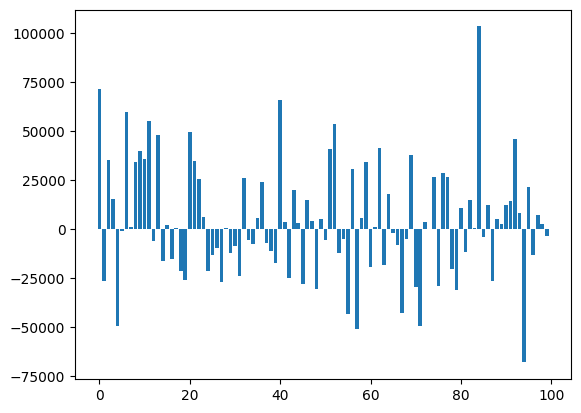

In [57]:
plt.bar(range(len(profit_RL_original)), profit_RL_original)

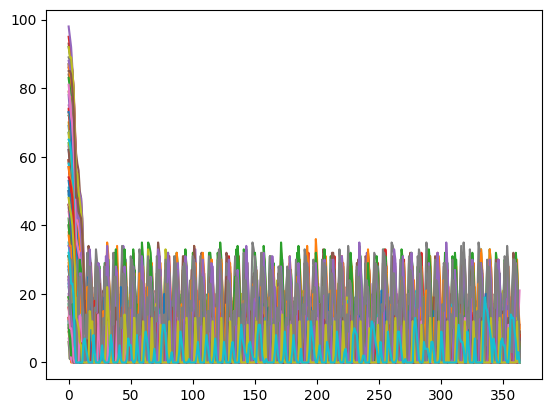

In [58]:
for level in invs_list_original:
  plt.plot(range(len(level)), level)

In [30]:
# Get RL method metrics
RL_mean = np.mean(profit_RL_list)
print("Mean reward for DQN method: ", RL_mean)

Mean reward for DQN method:  7753.050604497371


<BarContainer object of 100 artists>

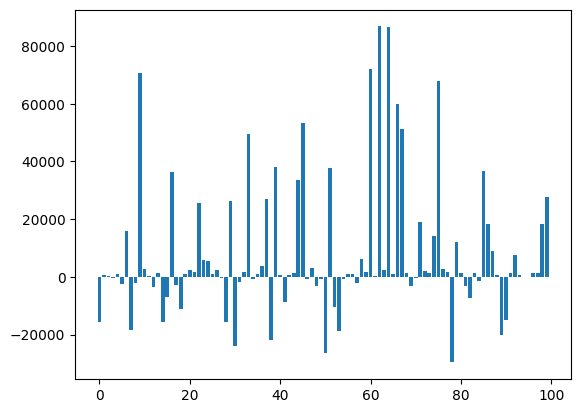

In [31]:
plt.bar(range(len(profit_RL_list)), profit_RL_list)

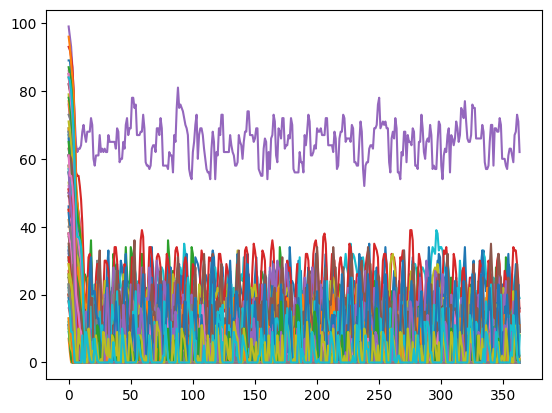

In [32]:
for level in inv_level_RL_list:
  plt.plot(range(len(level)), level)

# 6. Testing the best policy

Demand test is currently generated, so the sS method is tested using the same demand and parameters than DQN record.

In [33]:
# Get sS in the random option metrics
sS_mean = np.mean(profit_sS_list)
print("Mean reward for sS method: ", sS_mean)

Mean reward for sS method:  7882.883329992407


<BarContainer object of 100 artists>

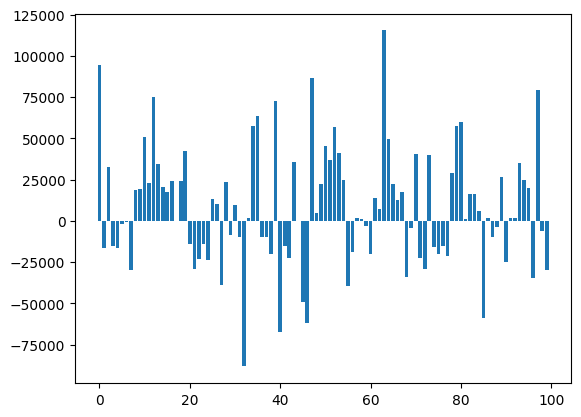

In [34]:
plt.bar(range(len(profit_sS_list)), profit_sS_list)

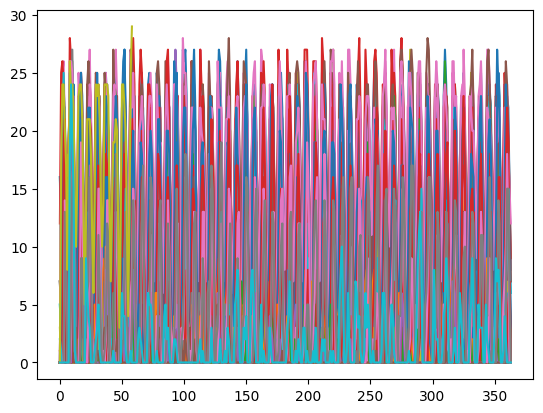

In [35]:
plt.figure()

for level in inv_level_sS_list:
  plt.plot(range(len(level)), level)

# 7. Comparing results

From s_S method to DQN, the results will vary in order to the deel RL method is able to adapt better with variabilities.

{'whiskers': [<matplotlib.lines.Line2D at 0x7e720ec1e260>,
 'caps': [<matplotlib.lines.Line2D at 0x7e720ec1e7a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e720ec1dfc0>,
 'medians': [<matplotlib.lines.Line2D at 0x7e720ec1ece0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7e720ec1ef80>,
 'means': []}

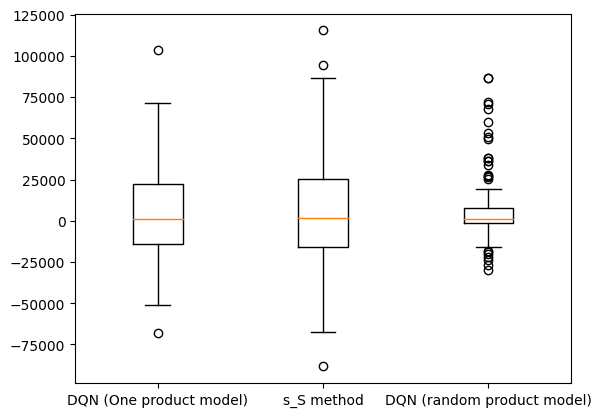

In [60]:
profit_list = []
profit_list.append(profit_RL_original)
profit_list.append(profit_sS_list)
profit_list.append(profit_RL_list)

labels = ['DQN (One product model)', 's_S method', 'DQN (random product model)']

plt.boxplot(profit_list, labels=labels)